In [27]:
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from ATLAS_data.effFunctions import eventEff,vertexEff
from atlas_susy_2018_13_Recast import (getLLPs, getJets, getDisplacedJets, eventAcc, 
                                       vertexAcc, getModelDict)


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution

delphesDir = os.path.abspath("../DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['YlGnBu']

In [14]:
inputFile = './ewk_Fig10b/Events/run_01/ewk_700_tau_1.00e-01_delphes_events.root'
sr = 'Trackless'

In [49]:
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
nevts = tree.GetEntries()
ntotal = 0
totalweightPB = 0.0
lumi = 139.0
mDV_nTracks_weights = []
for ievt in range(nevts):    
   
    ntotal += 1
    tree.GetEntry(ievt)   
    weightPB = tree.Weight.At(1).Weight     
    totalweightPB += weightPB
    ns = weightPB*1e3*lumi # number of signal events

    llps = getLLPs(tree.bsm,tree.bsmDirectDaughters,tree.bsmFinalDaughters)
    jets = getJets(tree.GenJet,pTmin=25.,etaMax=5.0)
    jetsDisp = getDisplacedJets(jets,llps)
    
    # Event acceptance:
    jet_acc = eventAcc(jets,jetsDisp,sr=sr)
    if (not jet_acc): continue
    ns = ns*jet_acc
    
    # Event efficiency
    ev_eff = eventEff(jets,llps,sr=sr,extrapolate=True)
    ns = ns*ev_eff
    # Vertex acceptances:
    v_acc = np.array([vertexAcc(llp,Rmax=300.0,zmax=300.0,Rmin=4.0,d0min=2.0) for llp in llps])
    # Vertex efficiencies:
    v_eff = np.array([vertexEff(llp,extrapolate=True) for llp in llps])
    
    v_acc = np.full(len(llps),fill_value=1.0)
    v_eff = np.full(len(llps),fill_value=1.0)
    

    for illp,llp in enumerate(llps):
        wv = v_acc[illp]*v_eff[illp]
        if wv <= 0.:
            continue
        mDV_nTracks_weights.append([llp.mDV,llp.nTracks,ns*wv])

f.Close()

In [50]:
mDV_nTracks_weights = np.array(mDV_nTracks_weights)

### ATLAS data

In [51]:
data_obs = np.genfromtxt('./ATLAS_data/HEPData-ins2628398-v1-csv/yields_trackless_SR_observed.csv',
                         delimiter=',',skip_header=10)
data_exp = np.genfromtxt('./ATLAS_data/HEPData-ins2628398-v1-csv/yields_trackless_SR_expected_ewk.csv',
                         delimiter=',',skip_header=11)

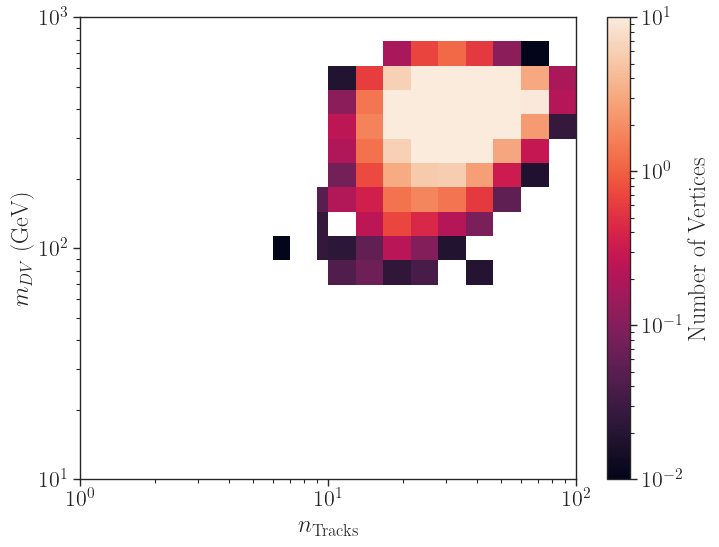

In [56]:
fig = plt.figure(figsize=(8,6))
mDV_bins = sorted(np.unique(data_exp[:,4]))
n_bins = sorted(np.unique(data_exp[:,1]))
mDV_bins = np.logspace(1,3,20)
n_bins = np.arange(1,10).tolist() + np.logspace(1,2,10).tolist()
h = plt.hist2d(mDV_nTracks_weights[:,1],mDV_nTracks_weights[:,0],
               weights=mDV_nTracks_weights[:,2],bins=(n_bins,mDV_bins),norm=LogNorm(vmin=1e-2,vmax=10))

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$m_{DV}$ (GeV)')
plt.xlabel(r'$n_{\rm Tracks}$')
fig.colorbar(h[3], ax=plt.gca(),label='Number of Vertices')
plt.show()
